In [1]:
import pandas as pd
import numpy as np
import matplotlib
import pymc3 as pm
import matplotlib.pyplot as plt

# Collect the data

Data is for event specified by the `event` variable

In [2]:
event = 6
fullData = pd.DataFrame()
for i in range(1,9):
    fullData = pd.concat([fullData, pd.read_csv('PMU{0}_event{1}.csv'.format(i,event), index_col='Time')], axis=1)

Clean up the column names so they are easier to work with - Make a MultiIndex of the form \[PMU#\]\[Phase A/B/C\]

In [3]:
fullData.columns = fullData.columns.map(lambda label: '{0}|{1}'.format(label.split('|')[-2],label.split('|')[-1]))

In [4]:
curMag = fullData[list(i for i in fullData.columns if 'ma' in i and 'I' in i)]
curMag.columns = curMag.columns.map(lambda label: label[0:7])

In [5]:
pmuCol = curMag.columns.map(lambda label: label.split('|')[0])
phaseCol = curMag.columns.map(lambda label: label.split('|')[1])
filteredData = curMag
filteredData.columns = [pmuCol, phaseCol]

Grab the data from 0 to 2s as our 'regular' operational data and plot the overall signal

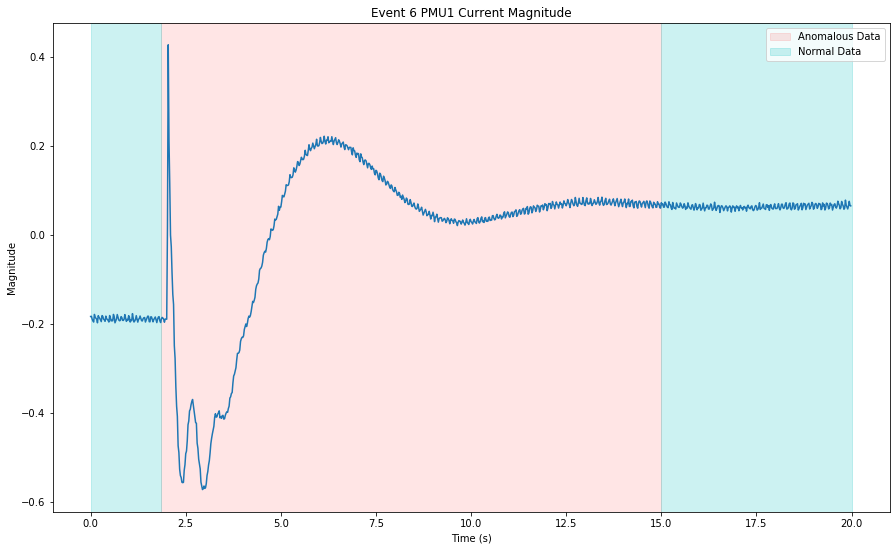

In [6]:
factor = 50
predict_cutoff_step = 93
end_anomaly = 750
pmu1B = filteredData['PMU1']['IB']
pmu1B = (pmu1B-pmu1B.mean())/(pmu1B.max()-pmu1B.min())
factor = 50
# Comment if you don't want to shorten the data set
pmu1B = pmu1B.groupby(np.arange(len(filteredData))//factor).mean()
# Add some noise
pmu1B = pmu1B+np.random.normal(0,0.002,len(pmu1B))
# Get the first 2 seconds and last 5 seconds
pmu1_normal =  pmu1B.loc[:predict_cutoff_step].append(pmu1B.loc[end_anomaly:])
fig, ax = plt.subplots(1,1, figsize = (15,9))
plt.title('Event {} PMU1 Current Magnitude'.format(event))
plt.plot(pmu1B.index/1000*20, pmu1B)
# pmu1B.plot(ax=ax, label = 'Anomaly Data', color = 'orange')
# pmu1_normal.loc[200:].plot(ax=ax, color = 'b', label = 'Training Data 1')
# pmu1_normal.loc[:200].plot(ax=ax, color = 'b', label= 'Training Data 2')
ax.axvspan(predict_cutoff_step/1000*20,end_anomaly/1000*20, alpha = 0.1, color = 'r', label = 'Anomalous Data')
ax.axvspan(0,predict_cutoff_step/1000*20, alpha=0.2,color='c', label = 'Normal Data')
ax.axvspan(end_anomaly/1000*20,20, alpha=0.2,color='c')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnitude')
ax.legend()
plt.show()

# Create the AR model and sample it

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, rho]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 12000/12000 [01:10<00:00, 169.46draws/s]


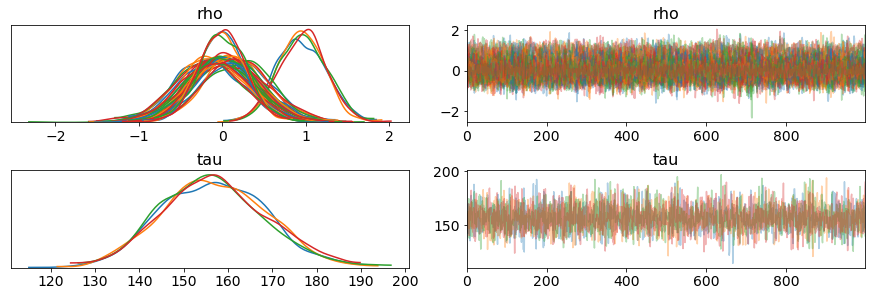

           mean      sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
rho[0]    0.952   0.288    0.426    1.496      0.006    0.004    2463.0   
rho[1]   -0.007   0.407   -0.777    0.761      0.009    0.007    2042.0   
rho[2]   -0.051   0.405   -0.817    0.723      0.008    0.006    2718.0   
rho[3]    0.082   0.402   -0.629    0.848      0.008    0.006    2798.0   
rho[4]    0.180   0.401   -0.596    0.928      0.008    0.007    2565.0   
rho[5]   -0.175   0.406   -0.922    0.590      0.008    0.006    2529.0   
rho[6]   -0.091   0.407   -0.817    0.695      0.009    0.006    2205.0   
rho[7]    0.046   0.395   -0.634    0.849      0.008    0.006    2437.0   
rho[8]    0.050   0.402   -0.696    0.813      0.008    0.007    2428.0   
rho[9]   -0.001   0.285   -0.532    0.525      0.005    0.004    2808.0   
tau     156.866  11.781  136.058  180.115      0.181    0.128    4253.0   

        ess_sd  ess_bulk  ess_tail  r_hat  
rho[0]  2401.0    2462.0    2776.0    1.0  
rho[1]  177

In [7]:
reg_order = 10

AR_Model = pm.Model()
with AR_Model:
    data = pm.Data('data', pmu1_normal)
    rho=pm.Uniform('rho',-5,5,shape=reg_order)
    tau =pm.Gamma('tau',mu=1,sd=1)
    obs=pm.AR('observed',rho=rho,tau=tau,observed=data)
    trace=pm.sample(1000, tune=2000)
    
pm.traceplot(trace)
plt.show()
print(pm.summary(trace))

Add the functions for predicting y(t) and graphing the prediction

In [8]:
"""
predict_AR function
trace: The trace that contains the AR parameters to use
horizon (int): how many time steps foward you would like to predict
y_initial (Series): the initial values for y to be used by the algorithm. Length of this is regression order
returns: a numpy array with one row per sample in the trace, one column per time value in horizon
"""

def predict_AR(trace, horizon, y_initial):
    rho = trace['rho'] # might need to reverse this
    order = len(y_initial)
    num_points = len(list(enumerate(trace.points())))
    y_t = np.zeros((num_points, horizon + order))
    y_t[:,0:order] = np.tile(y_initial,(num_points,1))
    for i in range(order,horizon+order):
        y_t[:,i] = np.sum(y_t[:,i-order:i]*rho,axis=1)
    return y_t[:,order-1:]

"""
get_percentile_df
turns a 5xN array of percentile values into a dataframe 
"""
def get_percentile_df(prediction):
    percentiles = np.percentile(prediction,[2.5,25,50,75,97.5],axis=0)
    # Put in a dataframe for easier access
    percentile_df = pd.DataFrame(
        {'5th Percentile': percentiles[0],
         '25th Percentile': percentiles[1],
         'Median': percentiles[2],
         '75th Percentile': percentiles[3],
         '95th Percentile': percentiles[4],
         'Mean': np.mean(prediction,axis=0)
        })
    return percentile_df

def plot_distribution_prediction(observed, percentile_df,ratio=1):
    fig,ax = plt.subplots(1,1,figsize=(15,9))
    ax.plot(observed.index*ratio,observed)
    ax.plot(percentile_df.index*ratio,percentile_df['Median'],alpha=0.75,color='k',label='Posterior median')
    ax.fill_between(percentile_df.index*ratio,percentile_df['5th Percentile'],percentile_df['95th Percentile'],alpha=0.5,color='c',label='Center 95%')
    ax.fill_between(percentile_df.index*ratio,percentile_df['25th Percentile'],percentile_df['75th Percentile'],alpha=0.2,color='b',label='Center 50%')
    ax.axvline(x=observed.index[-1]*ratio,linestyle='--',color='r', alpha=0.5, label = 'End of training data')
    ax.legend()
    ax.set_xlim(observed.index[0]*ratio,percentile_df.index[-1]*ratio)
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnitude')
    ax.set_title('Prediction of Current Magnitude')
    return fig, ax

def find_anomaly_index(actual, percentile_df):
    for idx in percentile_df.index:
        obs = actual.loc[idx]
        p95 = percentile_df.loc[idx]['95th Percentile']
        p5 = percentile_df.loc[idx]['5th Percentile']

        if obs < p5 or obs > p95:
            return idx

    return None
            

# Predict for future time steps and graph it

In [9]:
#Get a prediction for the next step_horizon periods
step_horizon = 10
prediction = predict_AR(trace,step_horizon,pmu1_normal.iloc[predict_cutoff_step-reg_order:predict_cutoff_step])
# Get the percentiles for the prediction and reindex for graphing
percentile_df = get_percentile_df(prediction)
percentile_df.index = percentile_df.index + predict_cutoff_step-1

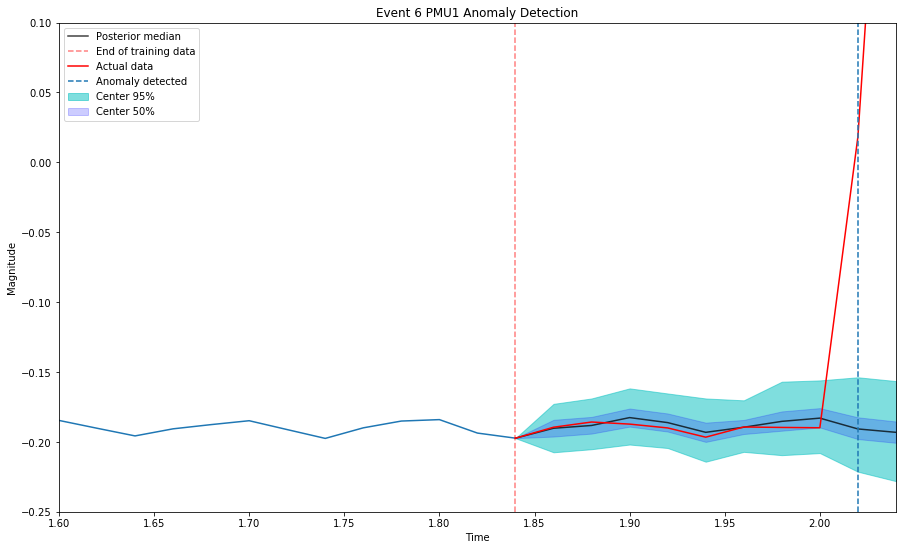

In [10]:
ratio = 20/1000

# Plot the predicted data
fig, ax = plot_distribution_prediction(pmu1_normal.iloc[80:predict_cutoff_step],percentile_df, ratio=ratio)

# Plot the actual data not used in the training
ax.plot(pmu1B.index[predict_cutoff_step-1:predict_cutoff_step+step_horizon]*ratio,
        pmu1B.iloc[predict_cutoff_step-1:predict_cutoff_step+step_horizon],
        label='Actual data',
        color = 'r')
ax.set_title('Event {} PMU1 Anomaly Detection'.format(event))
ax.set_ylim([-0.25,0.1])

#Find and plot the location of the first detected anomaly
anom_loc = find_anomaly_index(pmu1B,percentile_df)
if anom_loc is not None:
    plt.axvline(x=anom_loc*ratio, label = 'Anomaly detected', linestyle = '--')
else:
    print('No Anomalies detected')
ax.legend()

The anomaly is detected at around 170. Let's see what time that is in seconds

In [11]:
print('Anomaly detected at iloc[{0}], or {1}s'.format(anom_loc, anom_loc/1000*20))

Anomaly detected at iloc[101], or 2.02s
